In [1]:
import sys
print('Python: {}'.format(sys.version))

Python: 3.13.3 (main, Apr  8 2025, 13:54:08) [Clang 17.0.0 (clang-1700.0.13.3)]


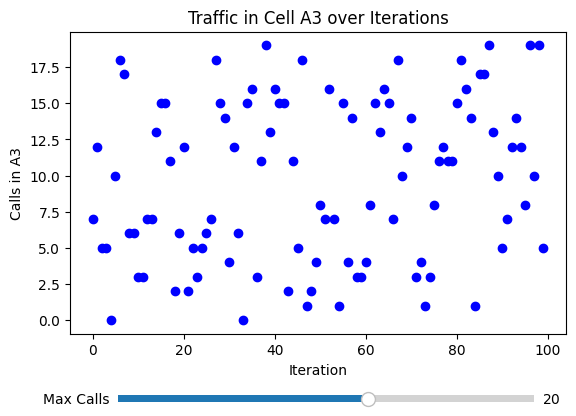

=== Final Report ===
Total Calls in A3: 968
DCA Blocked Calls: 0
FCA Blocked Calls: 0


In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from sklearn.cluster import KMeans
import scipy.special

# Erlang B formula
def erlang_b(traffic, channels):
    if traffic == 0:
        return 0  # No traffic means no blocking
    inv_b = 1.0
    for j in range(1, channels + 1):
        inv_b = 1 + (j / traffic) * inv_b
    return 1 / inv_b

# Spatial positions of cells
cell_positions = np.array([
    [0, 0],    # A3
    [1, 1],    # B1
    [-1, 1],   # C1
    [0, 2],    # B3
    [1, -1],   # C3
    [-1, -1],  # B5
    [0, -2]    # C5
])

# Initial parameters
MAX_CALLS = 20
PRIMARY_CHANNELS = 6
NUM_ITERATIONS = 100

def run_simulation(max_calls):
    total_calls_A3 = 0
    blocked_DCA = 0
    blocked_FCA = 0
    traffic_matrix = np.random.randint(0, max_calls, size=(NUM_ITERATIONS, 7))

    for calls in traffic_matrix:
        nA3 = calls[0]
        neighbors = calls[1:]
        total_calls_A3 += nA3

        # Erlang traffic assumption: 1 call = 0.1 Erlang
        erlangs = nA3 * 0.1
        block_prob = erlang_b(erlangs, PRIMARY_CHANNELS)

        # DCA
        if nA3 <= PRIMARY_CHANNELS or np.any(neighbors < PRIMARY_CHANNELS):
            pass
        else:
            blocked_DCA += int(block_prob * nA3)

        # FCA
        if nA3 > PRIMARY_CHANNELS:
            blocked_FCA += int(block_prob * nA3)

    return traffic_matrix, blocked_DCA, blocked_FCA, total_calls_A3

# Plotting setup
fig, ax = plt.subplots()
plt.subplots_adjust(bottom=0.25)

traffic_matrix, dca_blocked, fca_blocked, total_A3 = run_simulation(MAX_CALLS)
sc = ax.scatter(range(NUM_ITERATIONS), traffic_matrix[:, 0], c='blue')
ax.set_title("Traffic in Cell A3 over Iterations")
ax.set_xlabel("Iteration")
ax.set_ylabel("Calls in A3")

# Slider
axcolor = 'lightgoldenrodyellow'
ax_slider = plt.axes([0.2, 0.1, 0.65, 0.03], facecolor=axcolor)
slider = Slider(ax_slider, 'Max Calls', 5, 30, valinit=MAX_CALLS, valstep=1)

def update(val):
    max_calls = int(slider.val)
    traffic_matrix, dca_blocked, fca_blocked, total_A3 = run_simulation(max_calls)
    sc.set_offsets(np.c_[range(NUM_ITERATIONS), traffic_matrix[:, 0]])
    fig.canvas.draw_idle()

slider.on_changed(update)

plt.show()

# Final report
print("=== Final Report ===")
print(f"Total Calls in A3: {total_A3}")
print(f"DCA Blocked Calls: {dca_blocked}")
print(f"FCA Blocked Calls: {fca_blocked}")


Total calls in A3 395
Blocked calls DCA 0
Blocked calls FCA 0


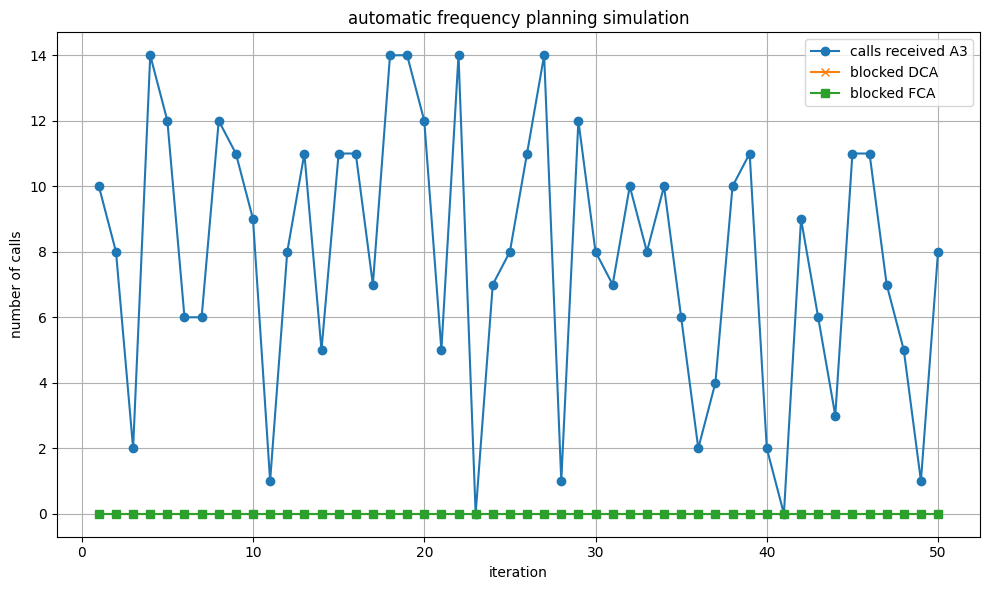

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# load data
file_path = '../Datasets/639.csv.gz'
df = pd.read_csv(file_path, compression='gzip', header=None)
df.columns = [
    'radio', 'mcc', 'net', 'area', 'cell', 'unit',
    'lat', 'lon', 'samples', 'changeable',
    'created', 'updated', 'averageSignal', 'dummy'
]

# use latitude and longitude to cluster into seven cells
coords = df[['lat', 'lon']].dropna()
kmeans = KMeans(n_clusters=7, random_state=0)
df.loc[coords.index, 'cluster'] = kmeans.fit_predict(coords)

# simulate traffic per tower for demo
np.random.seed(0)
df['traffic'] = np.random.randint(0, 15, size=len(df))

# define erlang B formula
def erlang_b(traffic, channels):
    if traffic == 0:
        return 0
    inv_b = 1.0
    for j in range(1, channels + 1):
        inv_b = 1 + (j / traffic) * inv_b
    return 1 / inv_b

# parameters
PRIMARY_CHANNELS = 6
ITERATIONS = 50

total_calls = []
blocked_dca = []
blocked_fca = []

for _ in range(ITERATIONS):
    loads = []
    for cid in range(7):
        tower_traffic = df[df.cluster == cid]['traffic']
        loads.append(int(tower_traffic.sample(1).iloc[0]))
    nA3 = loads[0]
    neighbors = loads[1:]
    total_calls.append(nA3)

    # dynamic channel allocation
    if nA3 <= PRIMARY_CHANNELS:
        bdca = 0
    elif sum(max(0, PRIMARY_CHANNELS - t) for t in neighbors) >= nA3 - PRIMARY_CHANNELS:
        bdca = 0
    else:
        overflow = nA3 - PRIMARY_CHANNELS - sum(max(0, PRIMARY_CHANNELS - t) for t in neighbors)
        traffic_erlang = nA3 * 3 / 60
        bdca = int(erlang_b(traffic_erlang, PRIMARY_CHANNELS) * overflow)
    blocked_dca.append(bdca)

    # fixed channel allocation
    if nA3 <= PRIMARY_CHANNELS:
        bfca = 0
    else:
        overflow = nA3 - PRIMARY_CHANNELS
        traffic_erlang = nA3 * 3 / 60
        bfca = int(erlang_b(traffic_erlang, PRIMARY_CHANNELS) * overflow)
    blocked_fca.append(bfca)

# summary
print('Total calls in A3', sum(total_calls))
print('Blocked calls DCA', sum(blocked_dca))
print('Blocked calls FCA', sum(blocked_fca))

# plot results
x = list(range(1, ITERATIONS + 1))
plt.figure(figsize=(10, 6))
plt.plot(x, total_calls, label='calls received A3', marker='o')
plt.plot(x, blocked_dca, label='blocked DCA', marker='x')
plt.plot(x, blocked_fca, label='blocked FCA', marker='s')
plt.xlabel('iteration')
plt.ylabel('number of calls')
plt.title('automatic frequency planning simulation')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
